# Reflexion Agentic RAG
### Reflexion: Language Agents with Verbal Reinforcement Learning


**Self-improving RAG system with iterative refinement**

This agent:
1. **Drafts** an initial answer and identifies missing information
2. **Retrieves** relevant documents using metadata filtering + BM25 ranking
3. **Revises** the answer with new information and reflects on completeness
4. **Repeats** until the answer is complete or max iterations reached

Features inline citations, financial keyword ranking, and autonomous search query generation for comprehensive answers from SEC filings.

https://arxiv.org/abs/2303.11366

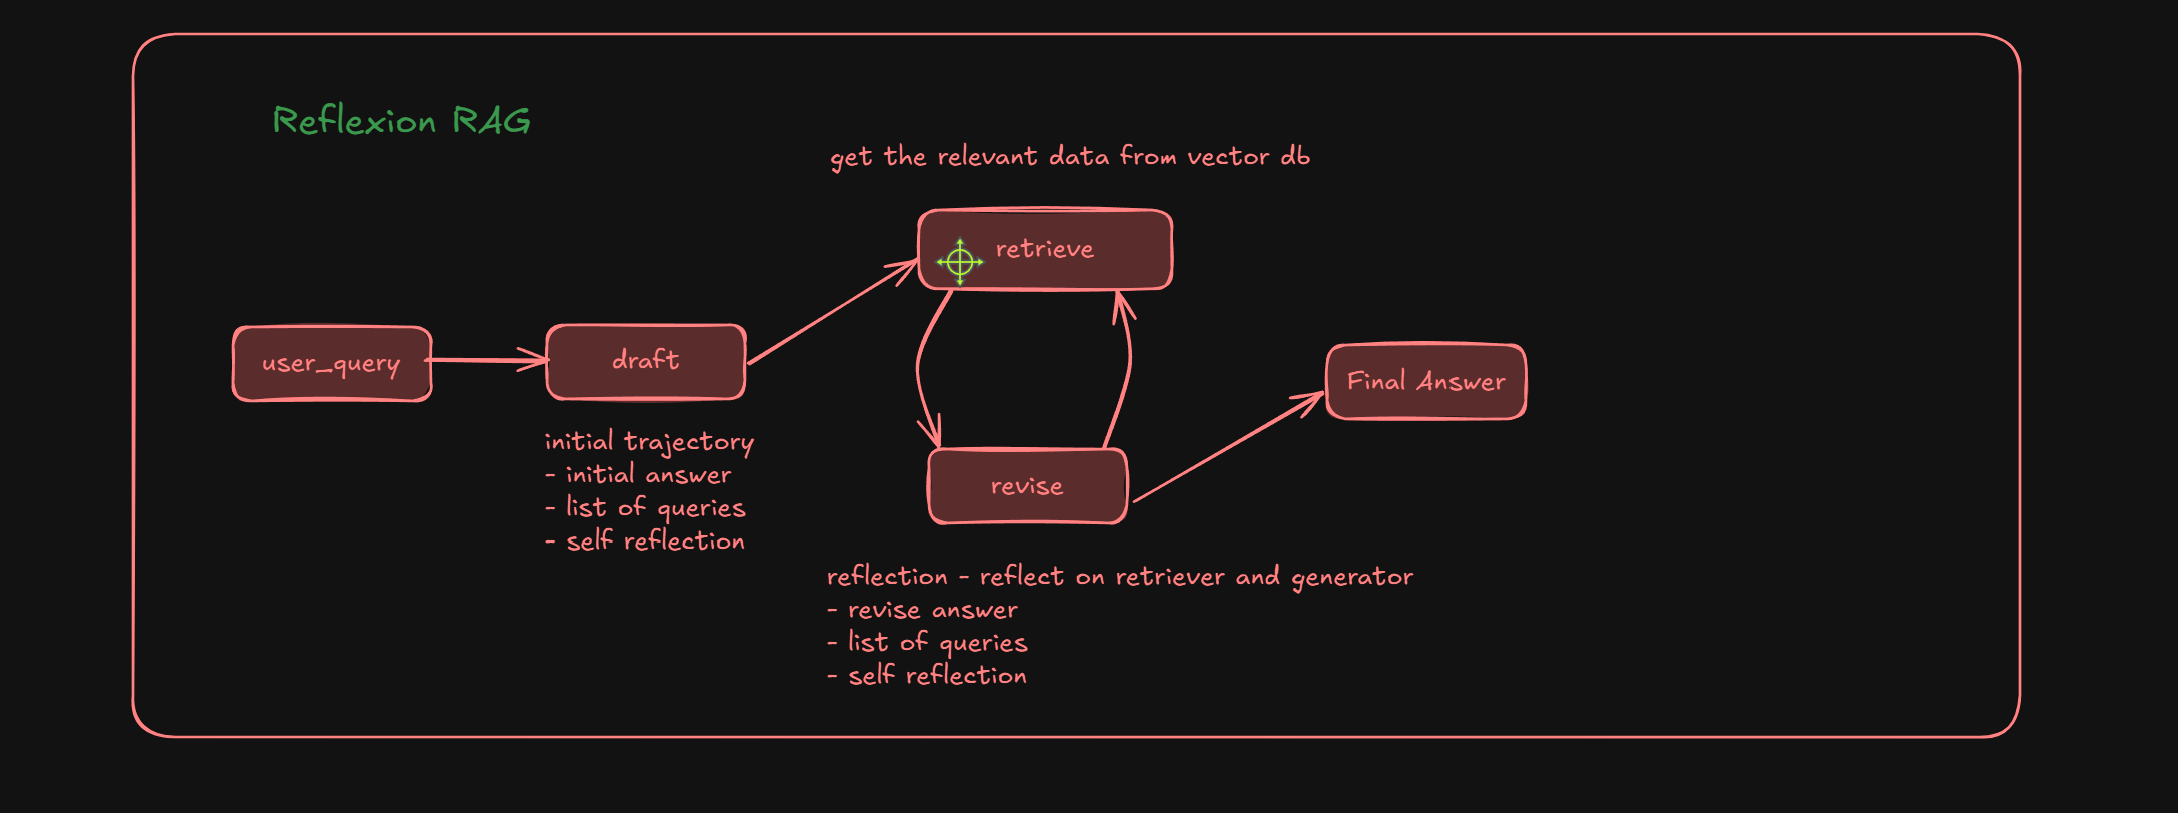

In [1]:
from typing_extensions import TypedDict, Annotated
from typing import Dict, List
import os

from langgraph.graph.message import add_messages
import operator

from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field

from scripts import my_tools

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# =============================================================================
# Configuration
# =============================================================================

BASE_URL = "http://localhost:11434"

# LLM_MODEL = "qwen3"
LLM_MODEL = "gpt-oss"

MAX_ITERATIONS = 3
llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

In [4]:
# =============================================================================
# Pydantic Schemas for Structured Output
# =============================================================================
class Reflection(BaseModel):
    """Critique of current answer"""
    missing: str = Field(description="What critical information is missing or incomplete")
    superfluous: str = Field(description="What information is unnessary or redundant")

class Answer(BaseModel):
    """Answer with inline citation, reflection and search queries"""
    answer: str = Field(description="Detailed answer with inline citation [1], [2] with reference list at the end")
    reflection: Reflection = Field(description="Critical reflection on the answer")
    search_queries: List[str] = Field(default_factory=list,description="1-3 search queries if more information needed, empty is complete")
    is_complete: bool = Field(default=False, description="True if answer is complete and no more searches needed")

In [5]:
# =============================================================================
# State
# =============================================================================
class AgentState(TypedDict):
    messages: Annotated[List, operator.add]
    iteration_count: int
    retrieved_docs: str
    search_queries: List[str]
    is_complete: bool

#### LangGraph Nodes

In [6]:
#Generate initial answer with reflection
# draft node

def draft_node(state:AgentState):
    
    llm_structured = llm.with_structured_output(Answer)

    system_prompt = """You are an expert financial document researcher.

              TASK:
              1. Provide detailed answer (~250 words) to user's question
              2. Use Markdown formatting (headings, bullets, tables, bold)
              3. Reflect critically: identify missing and superfluous information
              4. Generate 1-3 specific search queries to retrieve missing information

              Format your answer with inline citations [1], [2] if you have any prior knowledge to cite, otherwise note what information you need.

              Output JSON matching this schema:
              {
                "answer": "Your detailed answer with inline citations [1] and references at the end...",
                "reflection": {
                  "missing": "What information is missing...",
                  "superfluous": "What is unnecessary..."
                },
                "search_queries": ["specific query 1", "specific query 2"],
                "is_complete": false
              }""" 
    
    system_msg = SystemMessage(system_prompt)

    messages = [system_msg] + state['messages']

    response = llm_structured.invoke(messages)

    text_response = f"""
                      **Answer**: {response.answer}\n\n
                      **Reflection** - Missing: {response.reflection.missing}\n\n
                      **Reflection** - Superfluous: {response.reflection.superfluous}\n\n
                      **Search Queries**: {','.join(response.search_queries)}"""
    
    ai_msg = AIMessage(text_response)

    print(f"[DRAFT] Generated answer with {len(response.search_queries)}")

    return {
        'messages': [ai_msg],
        'iteration_count': 1,
        'search_queries': response.search_queries
    }


In [7]:
def retrieve_node(state: AgentState):

    print(f"[RETRIEVE] Fetching documents")

    search_queries = state.get('search_queries', [])

    if not search_queries:
        print(f"[RETRIEVE] No search queries are found. skipping the retrieval part.")
        return {'retrieved_docs': 'No document is retrieved as there is no search query.'}
    
    all_retrieved_text = []
    for idx, query in enumerate(search_queries, 1):
        print(f"[RETRIEVE] {idx} Query: {query}")
        
        # 3(Reranking) -> 3*10(Retrieval) -> 3*10*20 (MMR)
        result = my_tools.retrieve_docs.invoke({'query': query, 'k': 3})


        text = f"\n---- Query {idx}: {query}\n\nResult:\n{result}"
        all_retrieved_text.append(text)


    combined_result = "\n\n".join(all_retrieved_text)

    # Save for debugging
    os.makedirs('debug_logs', exist_ok=True)
    with open('debug_logs/reflexion_agentic_rag.md', 'w', encoding='utf-8') as f:
        f.write(combined_result)

    return {
        'retrieved_docs': combined_result
    }    


In [19]:
def revise_node(state: AgentState):

    print(f"[REVISE] Revise - Iteration {state.get('iteration_count', 1)}")
    llm_structured = llm.with_structured_output(Answer)

    system_prompt = """You are an expert financial document researcher.

                TASK:
                1. Write DETAILED answer (~250-300 words) with MARKDOWN formatting (## headings, **bold**, bullets, tables)
                2. Include inline citations [1], [2] in the answer text
                3. Add reference list at the end: "[1] Company: x, Year: y, Quarter: z, Page: n"
                4. Critically reflect on what's missing or superfluous
                5. Generate 2-3 SPECIFIC search queries if information is incomplete

                CRITICAL - Search Query Rules:
                - Use specific keywords: company name, year, quarter, metric type
                - Good: "Amazon q1 q2 2023 quarterly revenue", "Amazon 2023 AWS segment earnings"
                - Bad: "Amazon revenue", "financial data"

                DECISION LOGIC:
                Ask yourself:
                - Do I have complete quarterly breakdown? (Q1, Q2, Q3, Q4)
                - Do I have segment-wise data if relevant?
                - Do I have year-over-year comparisons?
                - Do I have all metrics requested (revenue, income, margins, etc.)?
                - Do I have all companies mentioned in the question?

                If ALL needed information present:
                {
                "answer": "## Complete answer with citations [1][2]...\n\n**References:**\n[1] Company: amazon, Year: 2023, Page: 5",
                "is_complete": true,
                "search_queries": [],
                "reflection": {"missing": "None", "superfluous": "None"}
                }

                If MISSING any required data:
                {
                "answer": "## Answer with available data [1]...\n\n**References:**\n[1] Company: amazon, Year: 2023, Page: 5",
                "is_complete": false,
                "search_queries": ["specific query 1", "specific query 2"],
                "reflection": {"missing": "List exact gaps", "superfluous": "None"}
                }

                MANDATORY: If is_complete=false, you MUST provide 2-3 specific search_queries."""
    
    query_prompt = f"""
                    Retrieved document:
                    {state.get('retrieved_docs', 'No doc found.')}

                    Revise your answer using these documents. Output JSON only data.
                    """
    

    system_msg = SystemMessage(system_prompt)
    messages = [system_msg] + state['messages'] + [HumanMessage(query_prompt)]

    response = llm_structured.invoke(messages)

    if not response.is_complete and not response.search_queries:
        print(f"[REVISE] WARNING - No search queries provided but answer is incomplete. Forcing completion.")
        response.is_complete=True

    print(f"[REVISE] Complete: {response.is_complete}")
    print(f"[REVISE] New Queries: {'\n'.join(response.search_queries)}")


    text_response = f"""
                      **Answer**: {response.answer}\n\n
                      **Reflection** - Missing: {response.reflection.missing}\n\n
                      **Reflection** - Superfluous: {response.reflection.superfluous}\n\n
                      **Search Queries**: {','.join(response.search_queries)}\n\n
                    **Status** {'Complete' if response.is_complete else 'Needs more information'}"""
    
    ai_msg = AIMessage(text_response)

    return {
        'messages': [ai_msg],
        'iteration_count': state.get('iteration_count', 1) + 1,
        'search_queries': response.search_queries,
        'is_complete': response.is_complete
    }


In [20]:
# =============================================================================
# Router Logic
# =============================================================================
def should_continue(state: AgentState):

    iteration_count = state.get('iteration_count', 0)
    is_complete = state.get('is_complete', False)
    search_queries = state.get('search_queries', [])

    if is_complete or not search_queries or iteration_count >= MAX_ITERATIONS:
        print(f"[ROUTER] iteration count: {iteration_count}\nis_complete: {is_complete}\nsearch_queries: {search_queries}")
        return END
    
    print(f"[ROUTER] Iteration {iteration_count} - continue to retrieve")
    return 'retrieve'


In [21]:
# =============================================================================
# Build Graph
# =============================================================================

def create_reflexion_agent():


    builder = StateGraph(AgentState)

    # add nodes
    builder.add_node('draft', draft_node)
    builder.add_node('retrieve', retrieve_node)
    builder.add_node('revise', revise_node)

    # define edges
    builder.add_edge(START, 'draft')
    builder.add_edge('draft', 'retrieve')
    builder.add_edge('retrieve', 'revise')
    
    # router logic
    builder.add_conditional_edges('revise', should_continue, ['retrieve', END])

    return builder.compile()

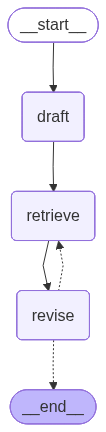

In [22]:
agent = create_reflexion_agent()

agent

#### Performance Testing

In [23]:
query = "what is amazon's balance sheet in 2023?"

result = agent.invoke({'messages': [HumanMessage(query)]})

[DRAFT] Generated answer with 3
[RETRIEVE] Fetching documents
[RETRIEVE] 1 Query: Amazon 2023 balance sheet figures 10-K

[TOOL] retrieve_docs called
[QUERY] Amazon 2023 balance sheet figures 10-K
   [1] Doc 6: score=24.1301
   [2] Doc 18: score=22.8476
   [3] Doc 12: score=21.9673
[RETRIEVED] 3 documents
[RETRIEVE] 2 Query: Amazon total assets liabilities equity 2023

[TOOL] retrieve_docs called
[QUERY] Amazon total assets liabilities equity 2023
   [1] Doc 3: score=21.6844
   [2] Doc 2: score=18.2205
   [3] Doc 6: score=17.8126
[RETRIEVED] 3 documents
[RETRIEVE] 3 Query: Amazon 2023 annual report financial statements

[TOOL] retrieve_docs called
[QUERY] Amazon 2023 annual report financial statements
   [1] Doc 21: score=31.0462
   [2] Doc 3: score=27.3715
   [3] Doc 7: score=27.1297
[RETRIEVED] 3 documents
[REVISE] Revise - Iteration 1
[REVISE] WARNING - No search queries provided but answer is incomplete. Forcing completion.
[REVISE] Complete: True
[REVISE] New Queries: 
[ROUTER] it

In [27]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================


                      **Answer**: ## Amazon 2023 Balance Sheet Snapshot

The 2023 Form 10‑K for Amazon does not provide a single consolidated balance‑sheet figure in the excerpts supplied. Below is the best‑effort summary of the line items that were located:

| Item | 2023 (USD bn) |
|------|---------------|
| Cash & cash equivalents | 73.4 |
| Marketable securities (short‑term) | – |
| Property & equipment (net) | 204.2 |
| Goodwill & indefinite‑lived intangible assets | – |
| Long‑term debt | 58.3 |
| Long‑term lease liabilities | 77.3 |
| Total current liabilities | – |
| Total equity | – |

*The totals for current assets, other assets, total liabilities, and equity are missing from the extracted passages. To obtain a full balance sheet you will need to consult the “Consolidated Balance Sheets” section of the 2023 10‑K, typically on pages 27–30 of the filing.*




                      **Reflection** 

In [28]:
query = "Show segment wise earning for Iphones and Macbooks in 2023"

result = agent.invoke({'messages': [HumanMessage(query)]})

result['messages'][-1].pretty_print()


[DRAFT] Generated answer with 3
[RETRIEVE] Fetching documents
[RETRIEVE] 1 Query: Apple 2023 Form 10-K iPhone segment revenue

[TOOL] retrieve_docs called
[QUERY] Apple 2023 Form 10-K iPhone segment revenue
   [1] Doc 0: score=30.1964
   [2] Doc 1: score=24.6650
   [3] Doc 7: score=21.4384
[RETRIEVED] 3 documents
[RETRIEVE] 2 Query: Apple 2023 Form 10-K Mac segment revenue

[TOOL] retrieve_docs called
[QUERY] Apple 2023 Form 10-K Mac segment revenue
   [1] Doc 0: score=32.5447
   [2] Doc 1: score=29.1661
   [3] Doc 4: score=24.5483
[RETRIEVED] 3 documents
[RETRIEVE] 3 Query: Apple 2023 annual report revenue by product segment

[TOOL] retrieve_docs called
[QUERY] Apple 2023 annual report revenue by product segment
   [1] Doc 1: score=15.8145
   [2] Doc 0: score=11.2471
   [3] Doc 2: score=10.9705
[RETRIEVED] 3 documents
[REVISE] Revise - Iteration 1
[REVISE] WARNING - No search queries provided but answer is incomplete. Forcing completion.
[REVISE] Complete: True
[REVISE] New Queries: 


In [29]:
query = "Compare the Amazon's and Apple's revenue of 2024 Q1?"

result = agent.invoke({'messages': [HumanMessage(query)]})

result['messages'][-1].pretty_print()

[DRAFT] Generated answer with 4
[RETRIEVE] Fetching documents
[RETRIEVE] 1 Query: Amazon Q1 2024 revenue $162.5B

[TOOL] retrieve_docs called
[QUERY] Amazon Q1 2024 revenue $162.5B
   [1] Doc 16: score=18.0322
   [2] Doc 2: score=16.5118
   [3] Doc 3: score=14.5992
[RETRIEVED] 3 documents
[RETRIEVE] 2 Query: Apple fiscal Q1 2024 revenue $123.9B

[TOOL] retrieve_docs called
[QUERY] Apple fiscal Q1 2024 revenue $123.9B
   [1] Doc 1: score=20.9021
   [2] Doc 4: score=20.5000
   [3] Doc 3: score=19.0497
[RETRIEVED] 3 documents
[RETRIEVE] 3 Query: Amazon Q1 2024 earnings release

[TOOL] retrieve_docs called
[QUERY] Amazon Q1 2024 earnings release
   [1] Doc 4: score=22.7977
   [2] Doc 14: score=21.3062
   [3] Doc 5: score=20.3948
[RETRIEVED] 3 documents
[RETRIEVE] 4 Query: Apple Q1 2024 earnings release

[TOOL] retrieve_docs called
[QUERY] Apple Q1 2024 earnings release
   [1] Doc 6: score=25.6400
   [2] Doc 2: score=21.5611
   [3] Doc 3: score=21.1325
[RETRIEVED] 3 documents
[REVISE] Revis